In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv')

Method          | Clusters | Silhouette | DB Index  
-------------------------------------------------------
K-Means         | 3        | 0.2856     | 1.2742    
Hierarchical    | 3        | 0.2901     | 1.0849    
KNN Graph       | 2        | 0.1847     | 1.2734    


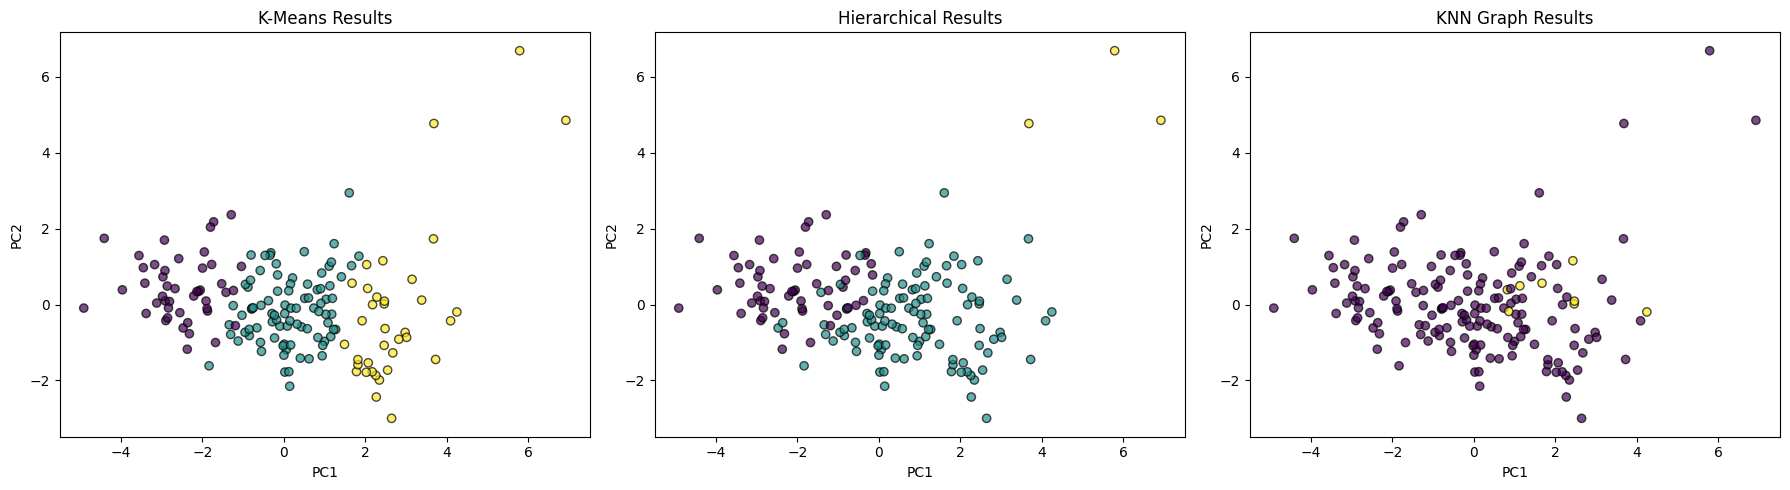

In [3]:
def scale_data(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std
def pca_scratch(X, n_components=2):
    X_centered = X - np.mean(X, axis=0)
    cov_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]
    components = eigenvectors[:, :n_components]
    return np.dot(X_centered, components)



# Run Algorithms
# Compute Metrics

# Print Results

# Visualization


In [4]:
def kmeans_scratch(X, k, max_iters=100, seed=42):
    """K-Means Clustering implementation."""
    np.random.seed(seed)
    # Randomly initialize centroids from data points
    idx = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[idx]

    for _ in range(max_iters):
        # Calculate Euclidean distances to centroids
        dists = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(dists, axis=1)

        # Update centroids to be the mean of points in each cluster
        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            points = X[labels == i]
            new_centroids[i] = np.mean(points, axis=0) if len(points) > 0 else X[np.random.choice(X.shape[0])]

        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return labels

def hierarchical_scratch(X, k_clusters):
    """Agglomerative Hierarchical Clustering (Complete Linkage)."""
    n = X.shape[0]
    dist_matrix = np.linalg.norm(X[:, np.newaxis] - X, axis=2)
    np.fill_diagonal(dist_matrix, np.inf)

    clusters = {i: [i] for i in range(n)}

    while len(clusters) > k_clusters:
        # Find the two closest clusters
        min_idx = np.argmin(dist_matrix)
        i, j = divmod(min_idx, dist_matrix.shape[1])

        # Merge cluster j into cluster i
        clusters[i].extend(clusters[j])
        del clusters[j]

        # Update distances using Complete Linkage (max distance between clusters)
        for m in clusters:
            if m == i: continue
            new_dist = max(dist_matrix[i, m], dist_matrix[j, m])
            dist_matrix[i, m] = dist_matrix[m, i] = new_dist

        dist_matrix[j, :] = dist_matrix[:, j] = np.inf

    labels = np.zeros(n, dtype=int)
    for cluster_id, (key, indices) in enumerate(clusters.items()):
        for idx in indices:
            labels[idx] = cluster_id
    return labels

def knn_graph_clustering(X, n_neighbors=3):
    """Clustering based on KNN graph connectivity (Connected Components)."""
    n = X.shape[0]
    dist_matrix = np.linalg.norm(X[:, np.newaxis] - X, axis=2)

    # Build adjacency matrix
    adj = np.zeros((n, n))
    for i in range(n):
        nn_indices = np.argsort(dist_matrix[i])[1:n_neighbors+1]
        adj[i, nn_indices] = 1
        adj[nn_indices, i] = 1

    # Find components using Breadth-First Search
    labels = -np.ones(n, dtype=int)
    cluster_id = 0
    for i in range(n):
        if labels[i] == -1:
            queue = [i]
            labels[i] = cluster_id
            while queue:
                u = queue.pop(0)
                for v in np.where(adj[u] == 1)[0]:
                    if labels[v] == -1:
                        labels[v] = cluster_id
                        queue.append(v)
            cluster_id += 1
    return labels

In [5]:

def silhouette_scratch(X, labels):
    """Calculate the average Silhouette Score."""
    n = X.shape[0]
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2: return 0.0

    dist_matrix = np.linalg.norm(X[:, np.newaxis] - X, axis=2)
    silhouettes = []

    for i in range(n):
        # a(i): average distance within same cluster
        same = np.where(labels == labels[i])[0]
        a_i = np.sum(dist_matrix[i, same]) / (len(same) - 1) if len(same) > 1 else 0

        # b(i): min average distance to other clusters
        b_i = np.inf
        for other in unique_labels:
            if other == labels[i]: continue
            other_pts = np.where(labels == other)[0]
            avg_dist = np.mean(dist_matrix[i, other_pts])
            b_i = min(b_i, avg_dist)

        s_i = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) > 0 else 0
        silhouettes.append(s_i)
    return np.mean(silhouettes)

def db_index_scratch(X, labels):
    """Calculate the Davies-Bouldin Index (lower is better)."""
    unique_labels = np.unique(labels)
    k = len(unique_labels)
    if k < 2: return np.inf

    centroids = np.array([np.mean(X[labels == l], axis=0) for l in unique_labels])
    scatters = np.array([np.mean(np.linalg.norm(X[labels == l] - centroids[i], axis=1))
                        for i, l in enumerate(unique_labels)])

    centroid_dists = np.linalg.norm(centroids[:, np.newaxis] - centroids, axis=2)

    db_scores = []
    for i in range(k):
        r_ij = [(scatters[i] + scatters[j]) / centroid_dists[i, j] for j in range(k) if i != j]
        db_scores.append(max(r_ij))
    return np.mean(db_scores)

In [6]:
X_raw = df.drop('country', axis=1).values
X_scaled = scale_data(X_raw)
X_pca = pca_scratch(X_scaled, 2)

In [7]:
k_val = 3
km_labels = kmeans_scratch(X_scaled, k=k_val)
hc_labels = hierarchical_scratch(X_scaled, k_clusters=k_val)
knn_labels = knn_graph_clustering(X_scaled, n_neighbors=2)

In [8]:
results = [
    ["K-Means", len(np.unique(km_labels)), silhouette_scratch(X_scaled, km_labels), db_index_scratch(X_scaled, km_labels)],
    ["Hierarchical", len(np.unique(hc_labels)), silhouette_scratch(X_scaled, hc_labels), db_index_scratch(X_scaled, hc_labels)],
    ["KNN Graph", len(np.unique(knn_labels)), silhouette_scratch(X_scaled, knn_labels), db_index_scratch(X_scaled, knn_labels)]
]


In [9]:
print(f"{'Method':<15} | {'Clusters':<8} | {'Silhouette':<10} | {'DB Index':<10}")
print("-" * 55)
for row in results:
    print(f"{row[0]:<15} | {row[1]:<8} | {row[2]:<10.4f} | {row[3]:<10.4f}")


Method          | Clusters | Silhouette | DB Index  
-------------------------------------------------------
K-Means         | 3        | 0.2856     | 1.2742    
Hierarchical    | 3        | 0.2901     | 1.0849    
KNN Graph       | 2        | 0.1847     | 1.2734    


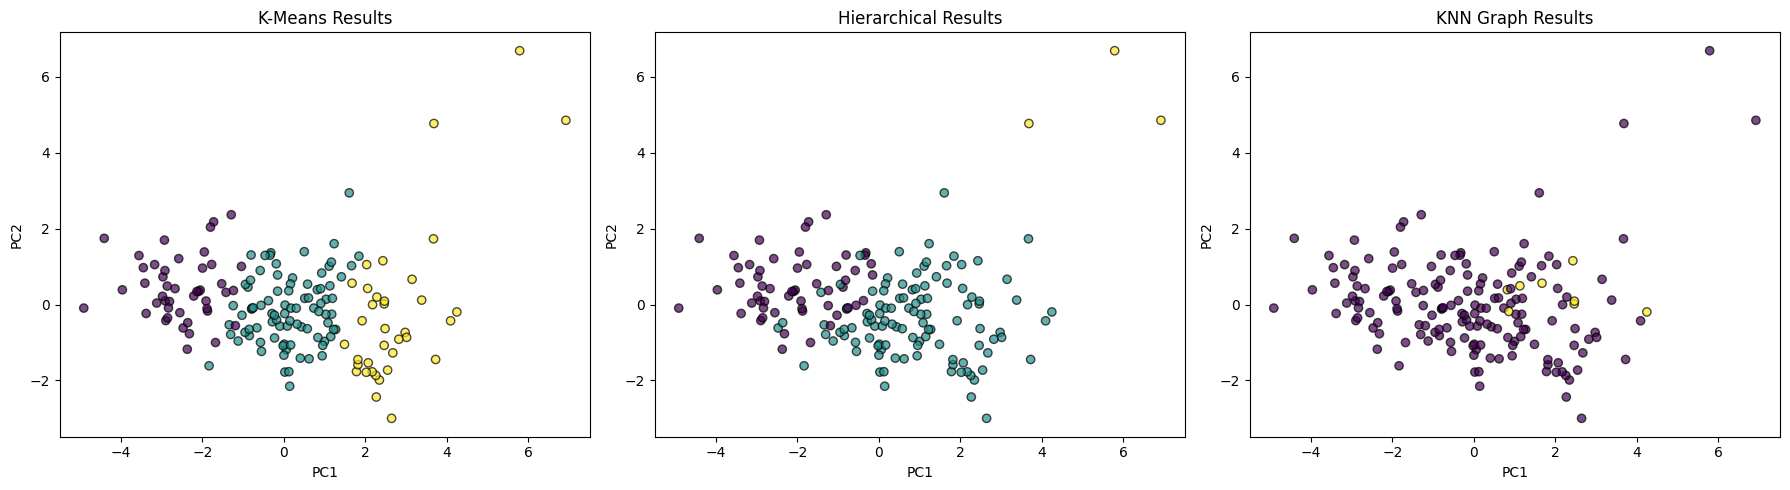

In [11]:
plt.figure(figsize=(18, 5))
titles = ["K-Means", "Hierarchical", "KNN Graph"]
all_labels = [km_labels, hc_labels, knn_labels]
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=all_labels[i], cmap='viridis', edgecolors='k', alpha=0.7)
    plt.title(f"{titles[i]} Results")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

plt.tight_layout()
plt.show()